In [69]:
import numpy as np
from sklearn.svm import SVC
import torch
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

In [70]:
def mean_euclidean_error(vectors1, vectors2):
    """
    Compute the mean Euclidean error between two sets of 3D vectors.

    Parameters:
    - vectors1: NumPy array of shape (N, 3) representing the first set of 3D vectors
    - vectors2: NumPy array of shape (N, 3) representing the second set of 3D vectors

    Returns:
    - mean_error: Mean Euclidean error between the two sets of vectors
    """
    # Check if the input arrays have the correct shape
    if vectors1.shape != vectors2.shape or vectors1.shape[1] != 3:
        raise ValueError("Input arrays must be of shape (N, 3)")

    # Compute Euclidean distance
    euclidean_distance = np.linalg.norm(vectors1 - vectors2, axis=1)

    # Calculate the mean Euclidean error
    mean_error = np.mean(euclidean_distance)

    return mean_error

In [ ]:
def preprocess_monk(file_name):
    '''
    Load data from the Monk dataset and preprocess using one-hot encoding.

    Parameters:
    - file_name (str): The file name of the dataset.

    Returns:
    - x (torch.Tensor): Input data after one-hot encoding.
    - y (torch.Tensor): Target data.
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None,
                     names=['_','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'],
                     index_col=False)

    # Extract input features and target variable
    x1, x2, x3, x4, x5, x6, target = (np.array(df[feature]) for feature in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'target'])

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Reshape and transform x1 using one-hot encoding
    input_one_hot = encoder.fit_transform(x1.reshape(-1, 1))

    # Loop through the remaining input features and concatenate one-hot encoded values
    for x in [x2,x3,x4,x5,x6]:
        data =x.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    # Convert to PyTorch tensors
    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

In [71]:
from sklearn.model_selection import train_test_split
# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]



# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
def perform_grid_search_kfold(kernels, Cs, k_folds, x, y):
    '''
    Perform grid search with k-fold cross-validation for Monk classifier hyperparameters.

    Parameters:
    - hidden_sizes (list): List of hidden layer sizes to explore.
    - learning_rates (list): List of learning rates to explore.
    - momentums (list): List of momentum values to explore.
    - batch_sizes (list): List of batch sizes to explore.
    - reg_coeffs (list): List of regularization coefficients to explore.
    - k_folds (int): Number of folds for cross-validation.
    - x (torch.Tensor): Input data.
    - y (torch.Tensor): Target data.
    - plot_curves (bool): Whether to plot training curves for each hyperparameter combination (default: False).

    Returns:
    - best_hyperparams (list): List of best hyperparameters based on highest average validation accuracy.
    '''

    best_acc = 0
    best_hyperparams = []

    for kernel, C in product(kernels, Cs):
        print('kernel:', kernel, 'C:',C)

        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and accuracies for each epoch
        val_acc = []
        svm_classifier_rbf = SVC(kernel='rbf', C=C)
        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            svm_classifier_rbf.fit(X_train, Y_train)
            y_pred_rbf = svm_classifier_rbf.predict(X_val)
            accuracy_rbf = accuracy_score(Y_val, y_pred_rbf)

            val_acc.append(accuracy_rbf)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_acc = {np.mean(train_acc):.4} +- {np.std(train_acc):.4} | '
            f'val_acc = {np.mean(val_acc):.4} +- {np.std(val_acc):.4}')

        if np.mean(val_acc) >= best_acc:
            best_acc = np.mean(val_acc)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

In [74]:
def plot_mean_std(cs,mee,std):

    plt.figure(figsize=(9, 8))
    plt.plot(cs,mee, label='MEE', color = 'green', linewidth=1)
    plt.fill_between(cs,mee-std, mee+std, color='green', alpha=0.3)

    plt.xlabel('C values')
    plt.ylabel('MEE')
    plt.legend()

    plt.legend()
    plt.show()


# Perform Grid Search

In [ ]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

In [75]:
'''
#first coarse grid search
kernels = ['rbf']
Cs = [0.01,0.1,1,10,100,1000]
epsilons = [0.01,0.1,1,10]
#Best Hp: ['rbf', 1000, 0.1] with MEE = 0.6396615599226871 +- 0.04980493197143183
'''

'''
#finer grid search
kernels = ['rbf']
Cs = [1000,2000,3000,4000,5000]
epsilons = [0.1,0.2,0.3,0.4,0.5]
# Best Hp: ['rbf', 3000, 0.1] with MEE = 0.6172759223965806 +- 0.06576969897515686
'''

#best hp untill now:
kernels = ['rbf']
Cs = [3000]
epsilons = [0.1]

best_hyperparams = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          k_folds=3,
                          x=X_train,
                          y=y_train)

total number of grid search combinations explored: 1
1/1 Hyperparams: rbf 3000 0.1


Final Results: kernel=rbf; C=3000; epsilon=0.1 --> val_mee = 0.6173 +- 0.06577
Best Hp: ['rbf', 3000, 0.1] with MEE = 0.6172759223965806 +- 0.06576969897515686


Study the effect of the parameter C

In [76]:
kernels = ['rbf']
Cs = np.arange(1000, 10000, 200)
epsilons = [0.1]


best_hyperparams, mees, mees_sd = perform_grid_search_kfold(kernels,
                          C05s,
                          epsilons,
                          k_folds=3,
                          x=X_train,
                          y=y_train,
                          return_sequence=True)

total number of grid search combinations explored: 45
1/45 Hyperparams: rbf 1000 0.1
Final Results: kernel=rbf; C=1000; epsilon=0.1 --> val_mee = 0.6397 +- 0.0498
2/45 Hyperparams: rbf 1200 0.1
Final Results: kernel=rbf; C=1200; epsilon=0.1 --> val_mee = 0.6319 +- 0.05173
3/45 Hyperparams: rbf 1400 0.1
Final Results: kernel=rbf; C=1400; epsilon=0.1 --> val_mee = 0.6262 +- 0.0549
4/45 Hyperparams: rbf 1600 0.1
Final Results: kernel=rbf; C=1600; epsilon=0.1 --> val_mee = 0.623 +- 0.05622
5/45 Hyperparams: rbf 1800 0.1
Final Results: kernel=rbf; C=1800; epsilon=0.1 --> val_mee = 0.6202 +- 0.05758
6/45 Hyperparams: rbf 2000 0.1
Final Results: kernel=rbf; C=2000; epsilon=0.1 --> val_mee = 0.6185 +- 0.0589
7/45 Hyperparams: rbf 2200 0.1
Final Results: kernel=rbf; C=2200; epsilon=0.1 --> val_mee = 0.6172 +- 0.06056
8/45 Hyperparams: rbf 2400 0.1
Final Results: kernel=rbf; C=2400; epsilon=0.1 --> val_mee = 0.6169 +- 0.06202
9/45 Hyperparams: rbf 2600 0.1
Final Results: kernel=rbf; C=2600; epsi

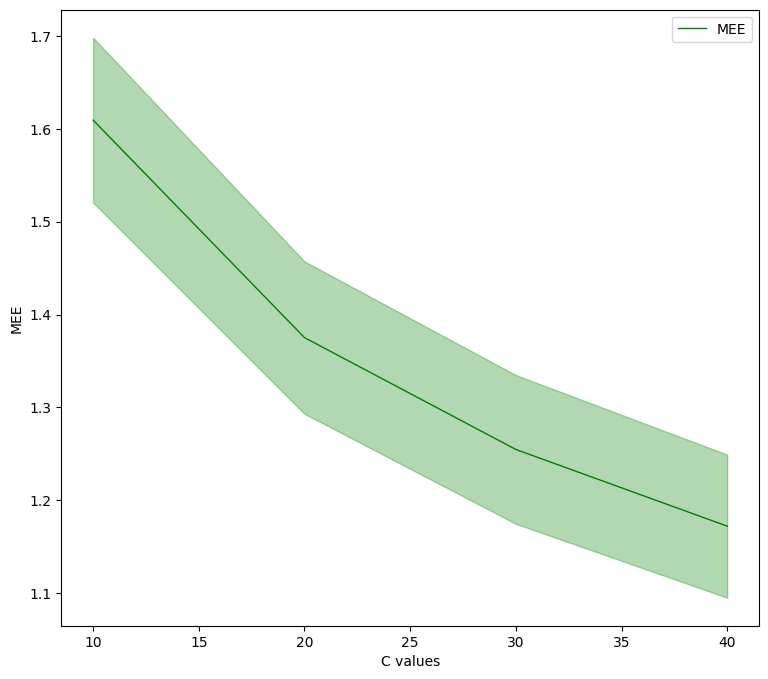

In [ ]:
plot_mean_std(Cs,mees,mees_sd)

# Train the final model on all the training data

In [ ]:
model = MultiSVM(*best_hyperparams)
model.fit(X_train,y_train)
print(mean_euclidean_error(model.predict(X_test),y_test))

1.0519287309492602
